In [58]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
#read in cell annotation file to split case/control samples
cell_anno = pd.read_csv("../../../results/data_preprocessing/Lasry/preprocessed/anno_cells_corr.txt", delimiter="\t")

/tmp/ipykernel_16734/4118805249.py:2: DtypeWarning: Columns (22,26,27,28,29,30,32,33,34,35,36,37,38,41,42,43,44,47,48,50,55,57,58,61,65,67,68,70) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_anno = pd.read_csv("../../../results/data_preprocessing/Lasry/preprocessed/anno_cells_corr.txt", delimiter="\t")


In [60]:
# Create a list of column names in the dataframe that contain the string "healthy"
control = cell_anno[cell_anno["health_status"]=="healthy"].sample_ID.unique()

# Create a list of column names in the dataframe that contain the string "AML"
case = cell_anno[cell_anno["health_status"]=="AML"].sample_ID.unique()


The variable ```XXX_anno``` is similar to the interactions_anno in the community. The purpose is to obtain the log2FC and p-values for each component of the interactions.

In [61]:
# Read in the CellPhoneDB results CSV file and set the interaction column as the index.
# Any missing values (NaNs) in the dataframe are filled with zeros.
# These missing values are due to merged samples.

cpdb = pd.read_csv('../../../results/method_comparison/compare_results/CPDB/CPDB_results.csv', index_col=None)
cpdb = cpdb.fillna(0)
cpdb.set_index("interaction", inplace=True)
cpdb_anno = pd.read_csv('../../../results/method_comparison/compare_results/CPDB/CPDB_anno_interaction.csv', index_col=None)
cpdb_anno.drop("Unnamed: 0", axis=1, inplace=True)

In [62]:
# Read in the NicheNet results CSV file and set the interaction column as the index.
# Any missing values (NaNs) in the dataframe are filled with zeros.
# These missing values are due to merged samples.
nnet = pd.read_csv("../../../results/method_comparison/compare_results/NicheNet/NicheNet_results.csv")
nnet_anno = pd.read_csv("../../../results/method_comparison/compare_results/NicheNet/NicheNet_anno_interaction.csv")
nnet = nnet.fillna(0)
nnet.set_index("interaction", inplace=True)
nnet_anno.drop("Unnamed: 0", axis=1, inplace=True)

In [63]:
community = pd.read_csv("../../../results/method_comparison/compare_results/community/community_results.csv")
community.rename(columns={"Unnamed: 0": "interaction"}, inplace=True)
community.set_index("interaction", inplace=True)
community_anno = pd.read_csv("../../../results/method_comparison/compare_results/community/community_anno_interactions.csv")
community_anno.drop("Unnamed: 0", axis=1, inplace=True)

community_anno_lower_threshold = pd.read_csv("../../../results/method_comparison/compare_results/community/community_anno_interactions_lower.csv")
community_anno_lower_threshold.drop("Unnamed: 0", axis=1, inplace=True)

# community_zero = pd.read_csv("../../../results/method_comparison/compare_results/community/community_results_0.csv")
# # community_zero.drop("Unnamed: 0", axis=1, inplace=True)

In [64]:
good_quality = community_anno[community_anno["passed_QC_filter"]==True]
community_good_quality = community[community.index.isin(good_quality["interaction_ID"])]

In [65]:
significant = community_anno[community_anno["sign"]==True]
community_significant=community[community.index.isin(significant["interaction_ID"])]

In [66]:
significant_lower_threshold = community_anno_lower_threshold[community_anno_lower_threshold["sign"]==True]
community_significant_lower_threshold=community[community.index.isin(significant_lower_threshold["interaction_ID"])]

In [67]:
def index_to_list(df):
    return df.index.values.tolist()

In [68]:
# below functions gets the number of non zero interactions in case/control. 
# the input is weight matrix and anno_interactions
def get_nr_samples(df, anno_df):
    mask_healthy = df.loc[:, control] != 0
    row_sums_healthy = np.sum(mask_healthy, axis=1)
    anno_df['nr_nonZero_controls'] = row_sums_healthy.values
    
    mask_case = df.loc[:, case] != 0
    row_sums_case = np.sum(mask_case, axis=1)
    anno_df['nr_nonZero_case'] = row_sums_case.values
    return anno_df

In [69]:
def plot_density(df_anno,title):
    # plot scatter plot
    sns.scatterplot(x=df_anno['nr_nonZero_controls'], y=df_anno['nr_nonZero_case'], s=20, alpha=0.5)

    # add 2D density plot
    sns.kdeplot(x=df_anno['nr_nonZero_controls'], y=df_anno['nr_nonZero_case'], 
                cmap="Blues", shade=True, alpha=0.7)

    # set labels
    plt.xlabel('number of control samples')
    plt.ylabel('number of case samples')
    plt.title(title)

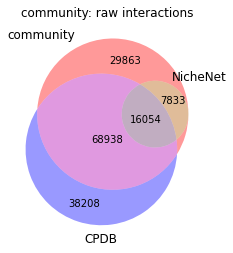

In [70]:
venn3([set(index_to_list(community)), set(index_to_list(nnet)), set(index_to_list(cpdb))], ("community", 'NicheNet', 'CPDB'))
plt.title("community: raw interactions")
plt.savefig('venn_raw_interactions.jpeg', bbox_inches='tight')

In [71]:
community_anno_raw = get_nr_samples(community, community_anno)

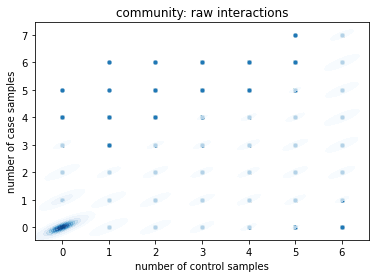

In [72]:
plot_density(community_anno_raw, "community: raw interactions")
plt.savefig('density_community_raw.jpeg', bbox_inches='tight')

In [73]:
nnet_anno = get_nr_samples(nnet, nnet_anno)

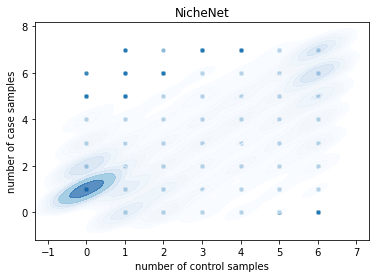

In [74]:
plot_density(nnet_anno, "NicheNet")
plt.savefig('density_NicheNet.jpeg', bbox_inches='tight')

In [75]:
cpdb_anno = get_nr_samples(cpdb, cpdb_anno)

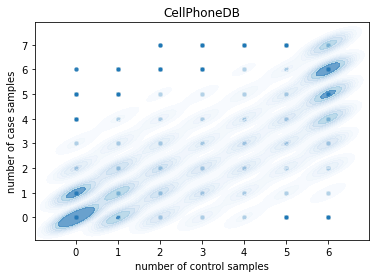

In [76]:
plot_density(cpdb_anno, "CellPhoneDB")
plt.savefig('density_CellPhoneDB.jpeg', bbox_inches='tight')

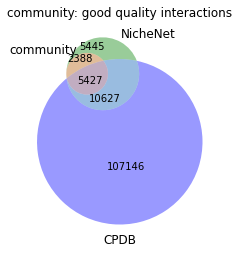

In [77]:
#good quality interactions from community

venn3([set(index_to_list(community_good_quality)), set(index_to_list(nnet)), set(index_to_list(cpdb))], ("community", 'NicheNet', 'CPDB'))
plt.title("community: good quality interactions")
plt.savefig('venn_good_quality.jpeg', bbox_inches='tight')

In [78]:
community_good_anno = community_anno_raw[community_anno_raw.interaction_ID.isin(index_to_list(community_good_quality))]

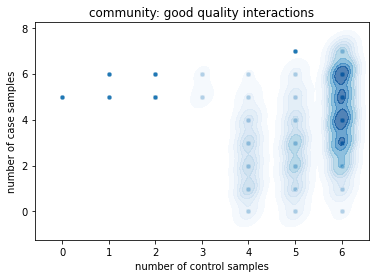

In [79]:
plot_density(community_good_anno, "community: good quality interactions")
plt.savefig('density_good_quality.jpeg', bbox_inches='tight')

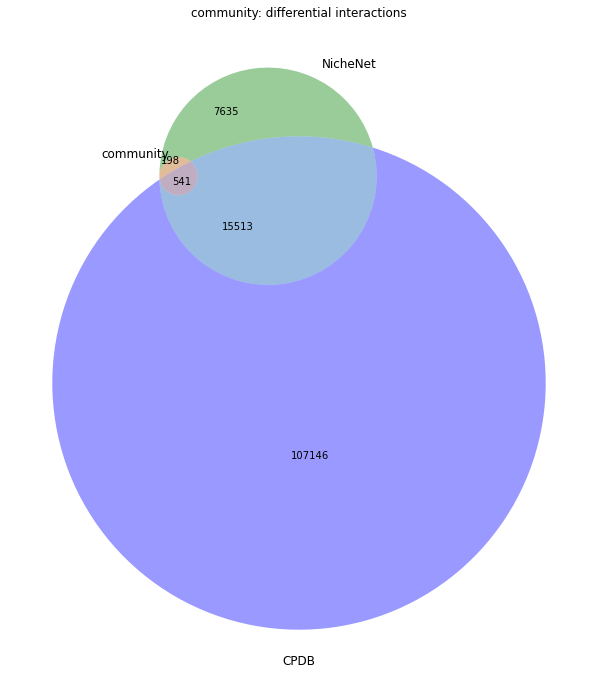

In [80]:
#significant interactions from community
fig = plt.figure(figsize=(12, 12))
venn3([set(index_to_list(community_significant)), set(index_to_list(nnet)), set(index_to_list(cpdb))], ("community", 'NicheNet', 'CPDB'))
plt.title("community: differential interactions")
plt.savefig('venn_significant.jpeg', bbox_inches='tight')

In [81]:
community_significant = community_anno_raw[community_anno_raw.interaction_ID.isin(index_to_list(community_significant))]

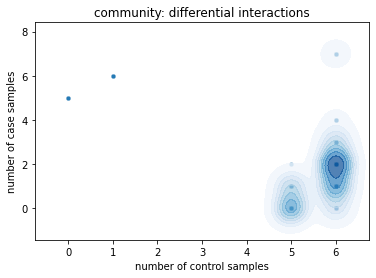

In [82]:
plot_density(community_significant, "community: differential interactions")
plt.savefig('density_significant.jpeg', bbox_inches='tight')

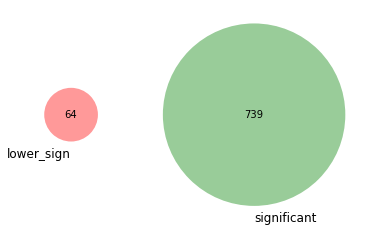

In [83]:
#significant interactions with lower thresholds

venn2([set(index_to_list(community_significant_lower_threshold)), set(index_to_list(community_significant))], ("lower_sign", 'significant'))
plt.savefig('venn_strict.jpeg', bbox_inches='tight')

In [84]:
community_strict = community_anno_raw[community_anno_raw.interaction_ID.isin(index_to_list(community_significant_lower_threshold))]

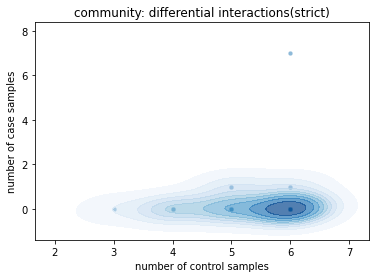

In [85]:
plot_density(community_strict, "community: differential interactions(strict)")
plt.savefig('density_strict.jpeg', bbox_inches='tight')

In [86]:
good_q=set(index_to_list(community_good_quality))
nnet_edges=set(index_to_list(nnet))

In [87]:
dif=nnet_edges.difference(good_q)

In [88]:
len(set(index_to_list(nnet)).difference(set(index_to_list(community_good_quality))))

16072

In [89]:
dif_anno=community_anno[community_anno.interaction_ID.isin(dif)]

In [90]:
failed_log10_cumw=dif_anno[dif_anno["passed_log10_cum_weight_filter"]==False]

In [91]:
failed_frac_samples=dif_anno[dif_anno["passed_frac_samples_filter"]==False]

In [92]:
failed_log10_cond=dif_anno[dif_anno["passed_log10_meanexpr_per_condition_filter"]==False]

In [93]:
failed_frac_samples.head()

,interaction_ID,ligand_gene_name,receptor_gene_name,sending_cell_type,receiving_cell_type,mean_e_s_l_control,mean_e_s_l_case,mean_e_r_r_control,mean_e_r_r_case,log2FC_rho_s,...,passed_log10_meanexpr_case_filter,passed_log10_meanexpr_per_condition_filter,passed_QC_filter,p.value,p.adj,passed_FDR_threshold,passed_log2FC_threshold,sign,nr_nonZero_controls,nr_nonZero_case
5,Mono:ADAM9_Mono:ITGA6,ADAM9,ITGA6,Mono,Mono,0.465697,0.635204,0.000000,0.078039,-0.454699,...,True,True,False,NaN,NaN,NaN,True,NaN,0,1
6,Mono:ADAM9_Mono:ITGAV,ADAM9,ITGAV,Mono,Mono,0.465697,0.635204,0.000000,0.077872,-0.454699,...,True,True,False,NaN,NaN,NaN,True,NaN,0,1
10,Mono:ANXA1_Mono:FPR2,ANXA1,FPR2,Mono,Mono,1.196629,1.261899,0.253094,0.000000,-0.454699,...,False,True,False,NaN,NaN,NaN,True,NaN,2,0
33,Mono:ICAM2_Mono:ITGB2,ICAM2,ITGB2,Mono,Mono,0.395314,0.443792,1.044343,1.055974,-0.454699,...,True,True,False,NaN,NaN,NaN,True,NaN,3,4
39,Mono:JAG1_Mono:NOTCH2,JAG1,NOTCH2,Mono,Mono,0.000000,0.092478,0.805527,0.633454,-0.454699,...,True,True,False,NaN,NaN,NaN,True,NaN,0,1


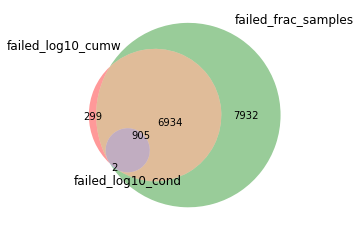

In [94]:
venn3([set(failed_log10_cumw["interaction_ID"]), set(failed_frac_samples["interaction_ID"]), set(failed_log10_cond["interaction_ID"])], ("failed_log10_cumw", 'failed_frac_samples', 'failed_log10_cond'))
plt.savefig('venn_failed_interactions.jpeg', bbox_inches='tight')

In [95]:
failed_frac_samples.reset_index(inplace=True)

In [96]:
nnet_frac = nnet[nnet.index.isin(failed_frac_samples["interaction_ID"])]

In [97]:
nnet_frac

,Unnamed: 0,AML-0024,AML-0160,AML-0693,AML-1371,AML-2123,AML-3133,AML-4340,healthy-1,healthy-2,healthy-3,healthy-4,healthy-4003,healthy-5
interaction,,,,,,,,,,,,,,
Mono:ACKR3_Mono:CXCR4,1,0.070204,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
Mono:ADAM10_Mono:CADM1,2,0.192146,0.0,0.000000,0.192146,0.0,0.192146,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
Mono:ADAM17_Mono:RHBDF2,7,0.483027,0.0,0.483027,0.483027,0.0,0.000000,0.483027,0.0,0.0,0.483027,0.0,0.483027,0.000000
Mono:ADM_Mono:ACKR3,9,0.274773,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
Mono:ANG_Mono:PLXNB2,12,0.101368,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ery:LRPAP1_Ery:SORL1,23883,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.128440,0.000000
Ery:ERFE_DC:LRP1,23884,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.049989,0.000000
Ery:RYK_DC:FZD2,23885,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.132535,0.000000


In [98]:
dif_anno_nnet=nnet_anno[nnet_anno.interaction_id.isin(nnet_frac.index)]

In [99]:
nnet_frac

,Unnamed: 0,AML-0024,AML-0160,AML-0693,AML-1371,AML-2123,AML-3133,AML-4340,healthy-1,healthy-2,healthy-3,healthy-4,healthy-4003,healthy-5
interaction,,,,,,,,,,,,,,
Mono:ACKR3_Mono:CXCR4,1,0.070204,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
Mono:ADAM10_Mono:CADM1,2,0.192146,0.0,0.000000,0.192146,0.0,0.192146,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
Mono:ADAM17_Mono:RHBDF2,7,0.483027,0.0,0.483027,0.483027,0.0,0.000000,0.483027,0.0,0.0,0.483027,0.0,0.483027,0.000000
Mono:ADM_Mono:ACKR3,9,0.274773,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
Mono:ANG_Mono:PLXNB2,12,0.101368,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ery:LRPAP1_Ery:SORL1,23883,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.128440,0.000000
Ery:ERFE_DC:LRP1,23884,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.049989,0.000000
Ery:RYK_DC:FZD2,23885,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.132535,0.000000


In [100]:
dif_anno_nnet

,interaction_id,sender_cell_type,sender_gene,receiver_cell_type,receiver_gene,sender_pval,receiver_pval,sender_logfc,receiver_logfc,nr_nonZero_controls,nr_nonZero_case
0,Mono:ACKR3_Mono:CXCR4,Mono,ACKR3,Mono,CXCR4,0.0,0.0,0.259583,0.331253,0,1
1,Mono:ADAM10_Mono:CADM1,Mono,ADAM10,Mono,CADM1,NaN,NaN,NaN,NaN,0,3
6,Mono:ADAM17_Mono:RHBDF2,Mono,ADAM17,Mono,RHBDF2,NaN,NaN,NaN,NaN,2,4
8,Mono:ADM_Mono:ACKR3,Mono,ADM,Mono,ACKR3,0.0,0.0,0.456472,0.259583,0,1
11,Mono:ANG_Mono:PLXNB2,Mono,ANG,Mono,PLXNB2,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
23882,Ery:LRPAP1_Ery:SORL1,Ery,LRPAP1,Ery,SORL1,NaN,NaN,NaN,NaN,1,0
23883,Ery:ERFE_DC:LRP1,Ery,ERFE,DC,LRP1,NaN,NaN,NaN,NaN,1,0
23884,Ery:RYK_DC:FZD2,Ery,RYK,DC,FZD2,NaN,NaN,NaN,NaN,1,0
23885,HSPC:VCAN_Ery:SELPLG,HSPC,VCAN,Ery,SELPLG,NaN,NaN,NaN,NaN,1,0


In [101]:
failed_frac_samples=get_nr_samples(nnet_frac, dif_anno_nnet)

/tmp/ipykernel_16734/3536078387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df['nr_nonZero_controls'] = row_sums_healthy.values
/tmp/ipykernel_16734/3536078387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df['nr_nonZero_case'] = row_sums_case.values


## why there are so many 0s

In [102]:
 failed_frac_samples["tuple"]=list(zip(failed_frac_samples.nr_nonZero_controls, failed_frac_samples.nr_nonZero_case))

/tmp/ipykernel_16734/3653865036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_frac_samples["tuple"]=list(zip(failed_frac_samples.nr_nonZero_controls, failed_frac_samples.nr_nonZero_case))


In [103]:
failed_frac_samples[failed_frac_samples["tuple"]==(0,0)]

,interaction_id,sender_cell_type,sender_gene,receiver_cell_type,receiver_gene,sender_pval,receiver_pval,sender_logfc,receiver_logfc,nr_nonZero_controls,nr_nonZero_case,tuple


In [104]:
community[community.index.isin(failed_frac_samples.interaction_id)]

,AML-0024,AML-0160,AML-0693,AML-1371,AML-2123,AML-3133,AML-4340,healthy-1,healthy-2,healthy-3,healthy-4,healthy-4003,healthy-5
interaction,,,,,,,,,,,,,
Mono:ADAM9_Mono:ITGA6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.006987,0.0,0.0,0.000000,0.000000,0.000000,0.0
Mono:ADAM9_Mono:ITGAV,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.006987,0.0,0.0,0.000000,0.000000,0.000000,0.0
Mono:ANXA1_Mono:FPR2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.030874,0.086322,0.000000,0.0
Mono:ICAM2_Mono:ITGB2,0.619065,0.114257,0.0,0.009788,0.0,0.008559,0.000000,0.0,0.0,0.024532,0.037714,0.070951,0.0
Mono:JAG1_Mono:NOTCH2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.004282,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DC:VEGFB_DC:NRP1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.027348,0.0,0.0,0.000000,0.091127,0.000000,0.0
DC:YBX1_DC:NOTCH1,0.000000,0.000000,0.0,0.246609,0.0,0.000000,0.036713,0.0,0.0,0.000000,0.068964,0.000000,0.0
DC:ZYX_DC:ENG,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.047519,0.000000,0.0


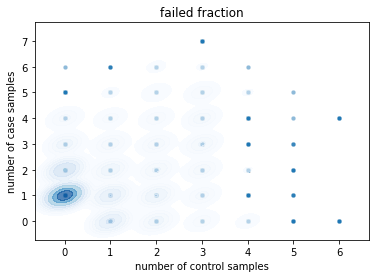

In [105]:
plot_density(failed_frac_samples,"failed fraction")
plt.savefig('density_failed_interactions.jpeg', bbox_inches='tight')

In [106]:
# def plot_scatter2(df):
    
    
#     df["tuple"]=list(zip(df.nr_nonZero_controls, df.nr_nonZero_case))
#     df_group=df.groupby('tuple').sum()
    
    
#     x_max = max(df_group['nr_nonZero_controls'])+250
#     y_max = max(df_group['nr_nonZero_case'])+250

#     plt.scatter(x=df_group['nr_nonZero_controls'], y=df_group['nr_nonZero_case'])
#     plt.plot([0, x_max], [0, y_max], color='red')

#     plt.xlabel('nr_nonZero_controls')
#     plt.ylabel('nr_nonZero_cases')
    
    
    

# #     plt.plot([0,4.5], [0,4.5], color='red')
#     plt.xlim(0,x_max)
#     plt.ylim(0,y_max)
    
#     # plt.xscale("log")
#     # plt.yscale("log")

#     # Add diagonal line
#     # log_min_val = min(min(np.log10(nnet_anno_group['nr_nonZero_controls'])), min(np.log10(nnet_anno_group['nr_nonZero_case'])))
#     # log_max_val = max(max(np.log10(nnet_anno_group['nr_nonZero_controls'])), max(np.log10(nnet_anno_group['nr_nonZero_case'])))

#     # transformed_min_val = 10**log_min_val
#     # transformed_max_val = 10**log_max_val

#     # plt.plot([transformed_min_val, transformed_max_val], [transformed_min_val, transformed_max_val], 'r--')


#     plt.show()

In [107]:
# plot_scatter2(failed_frac_samples)

In [108]:
# Each column contains a list of two values: the number of interactions in the case group and the control group


plotdata = pd.DataFrame({

    "community":[len(index_to_list(community))],

    "NicheNet":[len(index_to_list(nnet))],

    "CPDB":[len(index_to_list(cpdb))]},

    index=["# of total interactions"])

In [109]:
plotdata

,community,NicheNet,CPDB
# of total interactions,122688,23887,123200


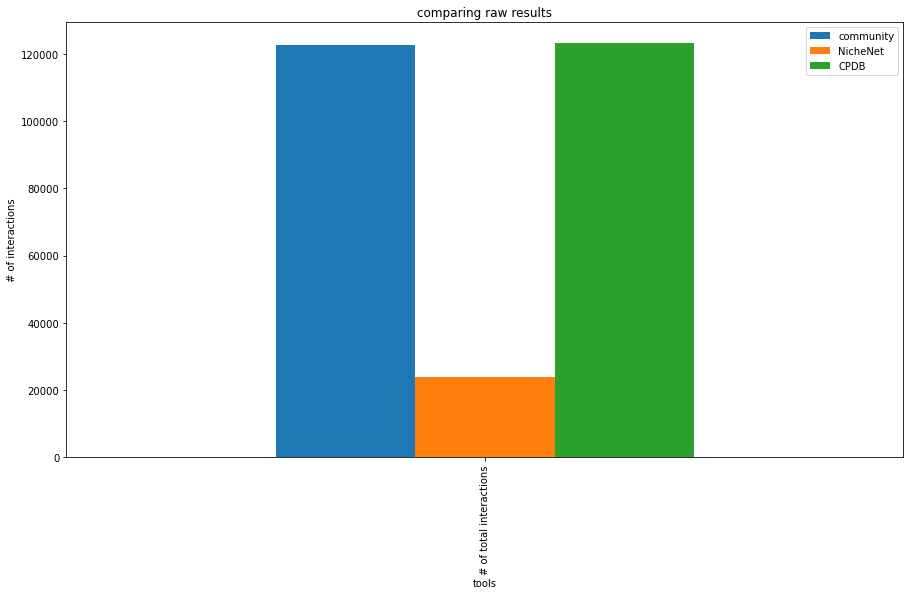

In [110]:
plotdata.plot(kind="bar",figsize=(15, 8))

plt.title("comparing raw results")

plt.xlabel("tools")

plt.ylabel("# of interactions")
plt.savefig('barplot_raw_interactions.jpeg', bbox_inches='tight')

In [111]:
# Each column contains a list of two values: the number of interactions in the case group and the control group


plotcommunity = pd.DataFrame({

    "community_raw":[len(index_to_list(community))],

    "community_good_quality":[len(index_to_list(community_good_quality))],

    "community_significant":[len(index_to_list(community_significant))],
    "community_significant_lower":[len(index_to_list(community_significant_lower_threshold))]},
    

    index=["# of total interactions"])

In [112]:
plotcommunity

,community_raw,community_good_quality,community_significant,community_significant_lower
# of total interactions,122688,7815,739,64


In [113]:
# plotcommunity.plot(kind="bar",figsize=(15, 8))

# plt.title("comparing raw results")

# plt.xlabel("tools")

# plt.ylabel("# of interactions")

In [114]:
# failed_frac_samples["tuple"]=list(zip(failed_frac_samples.nr_nonZero_controls, failed_frac_samples.nr_nonZero_case))
# df_group=failed_frac_samples.groupby('tuple').sum()

    
# x_max = max(df_group['nr_nonZero_controls'])+250
# y_max = max(df_group['nr_nonZero_case'])+250

# plt.scatter(x=df_group['nr_nonZero_controls'], y=df_group['nr_nonZero_case'])

# # loop through each point in the plot and add annotations
# for i, row in df_group.iterrows():
#     x = row['nr_nonZero_controls']
#     y = row['nr_nonZero_case']
#     label = f"({i[0]}, {i[1]})"
#     plt.annotate(label, (x, y))
    
# # add the diagonal line
# plt.plot([0, x_max], [0, y_max], color='red')

# # set the x-axis and y-axis limits
# plt.xlim(0, x_max)
# plt.ylim(0, y_max)

# # add x-axis and y-axis labels
# plt.xlabel('nr_nonZero_controls')
# plt.ylabel('nr_nonZero_cases')



# plt.show()